In [174]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os, pickle, random, operator, math
from collections import defaultdict
import matplotlib.pyplot as plt

In [188]:
def distance(instance1 , instance2 , k):
    distance = 0
    mm1, cm1 = instance1[0], instance1[1] 
    mm2, cm2 = instance2[0], instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance += (np.dot(np.dot((mm2 - mm1).transpose(), np.linalg.inv(cm2)), mm2 - mm1)) 
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [189]:
def getNeighbors(trainingSet, instance, k):
    distances =[]
    for i in range(len(trainingSet)):
        distances.append((trainingSet[i][2], 
                          distance(trainingSet[i], instance, k) + distance(instance, trainingSet[i], k)))
    distances.sort(key = operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors 

In [190]:
def nearestClass(neighbors):
    classVote = {}
    for i in range(len(neighbors)):
        response = neighbors[i]
        if response in classVote:
            classVote[response] += 1 
        else:
            classVote[response] = 1 
    return sorted(classVote.items(), key = operator.itemgetter(1), reverse = True)[0][0]

In [191]:
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (float(correct)) / len(testSet)

In [192]:
def confusionMatrix(testSet, predictions):
    matrix = np.zeros((10, 10))
    for i in range(len(predictions)):
        matrix[testSet[i][-1] - 1][predictions[i] - 1] += 1
    return matrix

In [193]:
def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va = 'center', ha = 'center')
        plt.show()

In [207]:
directory = "Data 2/genres_original/"
f = open("my.dat" ,'wb')
i = 0
for folder in os.listdir(directory):
    if folder == ".DS_Store":
        continue
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+folder): 
        if file == ".DS_Store" or file == "jazz.00054.wav":
            continue
        (rate,sig) = wav.read(directory + folder + "/" +file)
        mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix, covariance, i)
        pickle.dump(feature, f)
f.close()

In [208]:
dataset = []
def loadDataset(filename, split, trSet, teSet):
    with open("my.dat" , 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break  
    for i in range(len(dataset)):
        if random.random() < split :      
            trSet.append(dataset[i])
        else:
            teSet.append(dataset[i])  
trainingSet = []
testSet = []
loadDataset("my.dat" , 0.66, trainingSet, testSet)

In [209]:
n = len(testSet)
predictions = []
for i in range (n):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[i] , 4)))
accuracy1 = getAccuracy(testSet , predictions)
print(accuracy1)
confMatrix = confusionMatrix(testSet, predictions)

0.7002967359050445


<function matplotlib.pyplot.show(close=None, block=None)>

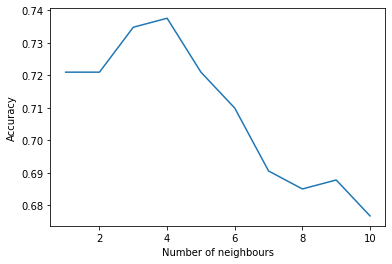

In [108]:
n = len(testSet)
accs = []
for k in range(1, 11): 
    predictions = []
    for i in range (n):
        predictions.append(nearestClass(getNeighbors(trainingSet, testSet[i] , k)))
    accs.append(getAccuracy(testSet, predictions))
plt.plot(range(1, 11), accs)
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy")
plt.show

[[27.  0.  3.  0.  1.  0.  0.  1.  0.  0.]
 [ 0. 27.  2.  2.  0.  0.  0.  2.  1.  0.]
 [ 1.  1. 25.  1.  2.  0.  2.  2.  0.  0.]
 [ 0.  0.  0. 22.  0.  0.  0.  2.  3.  0.]
 [ 0.  1.  2.  0. 25.  0.  1.  5.  0.  0.]
 [ 0.  0.  1.  0.  2. 33.  0.  0.  0.  1.]
 [ 1.  1.  9.  3.  4.  0. 20.  1.  4.  0.]
 [ 3.  2.  2.  0.  3.  0.  3. 32.  0.  0.]
 [ 0.  0.  1.  1.  2.  0.  4.  1. 24.  1.]
 [ 0.  0.  2.  0.  1.  5.  0.  0.  2. 32.]]


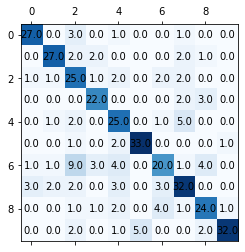

In [107]:
# 1 - pop
# 2 - metal 
# 3 - disco 
# 4 - blues 
# 5 - reggae
# 6 - classical
# 7 - rock
# 8 - hiphop
# 9 - country 
#10 - jazz
print(confMatrix)
display_confusion(confMatrix)
# which genres have higher accuracies 
# test with certain songs that are obviously part of a certain genre - accuracy test

In [210]:
results = defaultdict(int)
i = 1
for folder in os.listdir("/Users/jishnuraychaudhuri/Documents/CU Boulder/Courses/3. Junior/Semester 2/CSCI 4622/Project/Data 2/genres_original/"):
    if folder == ".DS_Store":
        continue
    results[i] = folder
    i += 1
print(results)

defaultdict(<class 'int'>, {1: 'pop', 2: 'metal', 3: 'disco', 4: 'blues', 5: 'reggae', 6: 'classical', 7: 'rock', 8: 'hiphop', 9: 'country', 10: 'jazz'})


In [211]:
testSongs = "22-30.wav billys_blues-30.wav enter_sandman-30.wav fur_elise-30.wav mercy_mercy_mercy-30.wav ny_state_of_mind-30.wav stayin_alive-30.wav sweet_child_o_mine-30.wav take_me_home_country_roads-30.wav three_little_birds-30.wav".split()
testResults = {}
for song in testSongs: 
    (rate, sig) = wav.read("tests/" + song)
    mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy = False)
    covariance = np.cov(np.matrix.transpose(mfcc_feat))
    mean_matrix = mfcc_feat.mean(0)
    feature = (mean_matrix,covariance,0)
    pred = nearestClass(getNeighbors(dataset ,feature , 5))
    testResults[song] = results[pred]

/var/folders/w3/bc1b1qks63988944mdvz6str0000gn/T/ipykernel_4650/1471026153.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (rate, sig) = wav.read("tests/" + song)


In [213]:
for s, p in testResults.items():
    print(s + ": " + p)

22-30.wav: pop
billys_blues-30.wav: hiphop
enter_sandman-30.wav: pop
fur_elise-30.wav: country
mercy_mercy_mercy-30.wav: reggae
ny_state_of_mind-30.wav: hiphop
stayin_alive-30.wav: pop
sweet_child_o_mine-30.wav: pop
take_me_home_country_roads-30.wav: pop
three_little_birds-30.wav: pop
